1. Imports and Setup

In [3]:
import os
import re
import string
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Colab file utilities (Jupyter mein yeh skip kar dein ya comment kar dein)
try:
    from google.colab import files
except Exception:
    files = None

# Visualization helper
from wordcloud import WordCloud


print("1) Ensuring NLTK stopwords are available...")
nltk.download('stopwords', quiet=True)
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

1) Ensuring NLTK stopwords are available...


2. Upload CSV File

In [4]:
# Jupyter mein file upload ke liye, aap manually file path set kar dein.
# Ya phir os.path use kar ke local file load karein.

if files is None:
    # Jupyter ke liye manual file path
    filename = input("Enter the path to your CSV file (e.g., 'spam.csv'): ").strip()
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File not found: {filename}")
    print("Using local file:", filename)
else:
    print("\n2) Upload your dataset CSV (e.g., spam.csv). Use the upload dialog that appears...")
    uploaded = files.upload()
    if not uploaded:
        raise FileNotFoundError("No file uploaded. Re-run the cell and upload the CSV file.")
    # take first uploaded file
    filename = next(iter(uploaded))
    print("Uploaded file:", filename)

Enter the path to your CSV file (e.g., 'spam.csv'):  spam.csv


Using local file: spam.csv


3. Read CSV with Encoding Fallback

In [5]:
print("\n3) Reading CSV (trying utf-8, latin1, iso-8859-1)...")
encodings = ['utf-8', 'latin1', 'iso-8859-1']
df = None
for enc in encodings:
    try:
        df = pd.read_csv(filename, encoding=enc, usecols=[0, 1])

        print(f"Read with encoding: {enc}")
        break
    except Exception as e:
        print(f"Failed with {enc}: {type(e).__name__}")
if df is None:
    raise ValueError("Unable to read CSV with tried encodings. Please check file or rerun with a different file.")

#Inspect & normalize columns
print("\n4) Inspecting columns:", list(df.columns))
# Common column names: 'v1','v2' or 'label','text' or 'class','message'
col_lower = [c.lower() for c in df.columns]

# find text column
text_col = None
for cand in ['text', 'message', 'body', 'msg', 'v2']:
    if cand in col_lower:
        text_col = df.columns[col_lower.index(cand)]
        break
# find label column
label_col = None
for cand in ['label', 'class', 'v1', 'type']:
    if cand in col_lower:
        label_col = df.columns[col_lower.index(cand)]
        break

if text_col is None or label_col is None:
    raise KeyError("Couldn't detect text and/or label columns automatically. Please ensure CSV has columns like ('v1','v2') or ('label','text'). Columns found: " + ", ".join(df.columns))

# rename for consistency
df = df.rename(columns={text_col: 'text', label_col: 'label'})
df = df[['text', 'label']].dropna().reset_index(drop=True)

print(f"Using text column: 'text' & label column: 'label' — sample rows: {min(3, len(df))}")
print(df.head(3))

# Normalize labels to lower-case strings
df['label'] = df['label'].astype(str).str.lower().str.strip()
# If labels are not ham/spam map: try common maps (1/0, spam/ham etc.)
if set(df['label'].unique()) - set(['spam','ham']) and set(df['label'].unique()) & set(['1','0','true','false']):
    # try numeric mapping
    df['label'] = df['label'].replace({'1': 'spam', '0': 'ham', 'true': 'spam', 'false': 'ham', 't': 'spam', 'f': 'ham'})
print("Label value counts:")
print(df['label'].value_counts())


3) Reading CSV (trying utf-8, latin1, iso-8859-1)...
Failed with utf-8: UnicodeDecodeError
Read with encoding: latin1

4) Inspecting columns: ['v1', 'v2']
Using text column: 'text' & label column: 'label' — sample rows: 3
                                                text label
0  Go until jurong point, crazy.. Available only ...   ham
1                      Ok lar... Joking wif u oni...   ham
2  Free entry in 2 a wkly comp to win FA Cup fina...  spam
Label value counts:
label
ham     4825
spam     747
Name: count, dtype: int64


4. Text Cleaning

In [6]:
print("\n5) Cleaning text (lowercase, remove non-letters, remove stopwords, stemming)...")
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # replace urls, emails, numbers with space
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)  # keep letters and spaces only
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [stemmer.stem(tok) for tok in tokens if tok not in stop_words]
    return " ".join(tokens)

# Apply cleaning with progress if large
df['clean_text'] = df['text'].apply(clean_text)
print("Example original -> cleaned:")
for i in range(min(2, len(df))):
    print("ORIG:", df['text'].iloc[i])
    print("CLEAN:", df['clean_text'].iloc[i])
    print("---")

# Remove rows with empty cleaned text
before = len(df)
df = df[df['clean_text'].str.strip() != ""].reset_index(drop=True)
after = len(df)
if before != after:
    print(f"Removed {before-after} rows with empty cleaned text.")


5) Cleaning text (lowercase, remove non-letters, remove stopwords, stemming)...
Example original -> cleaned:
ORIG: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
CLEAN: go jurong point crazi avail bugi n great world la e buffet cine got amor wat
---
ORIG: Ok lar... Joking wif u oni...
CLEAN: ok lar joke wif u oni
---
Removed 8 rows with empty cleaned text.


5. Feature Extraction (TF-IDF)

In [7]:
print("\n6) TF-IDF vectorization (max_features=5000)...")
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text']).toarray()
# Map labels to binary
label_map = {'ham': 0, 'spam': 1}
if not set(df['label'].unique()).issubset(set(label_map.keys())):
    # attempt to map anything else: take most frequent as ham and other as spam if unclear
    uniq = list(df['label'].unique())
    print("Unrecognized label values detected:", uniq)
    # try numeric mapping if possible
    df['label'] = df['label'].apply(lambda x: 'spam' if x in ['1','yes','y','spam'] else ('ham' if x in ['0','no','n','ham'] else x))
    # final fallback: map top freq to ham, rest to spam
    if not set(df['label'].unique()).issubset(set(label_map.keys())):
        most_common = df['label'].value_counts().idxmax()
        df['label'] = df['label'].apply(lambda x: 'ham' if x==most_common else 'spam')
y = df['label'].map(label_map).values

print("TF-IDF shape:", X.shape)
print("Label distribution (binary):")
print(pd.Series(y).value_counts())


6) TF-IDF vectorization (max_features=5000)...
TF-IDF shape: (5564, 5000)
Label distribution (binary):
0    4817
1     747
Name: count, dtype: int64


6. Data Splitting

In [8]:
print("\n7) Splitting data (train/test 80/20)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


7) Splitting data (train/test 80/20)...
Shapes: (4451, 5000) (1113, 5000) (4451,) (1113,)


7. Model Training


8) Training models: MultinomialNB, SVM (linear), RandomForest

Training Naive Bayes...
Naive Bayes Accuracy: 0.9668
Classification Report:
               precision    recall  f1-score   support

           0     0.9640    0.9990    0.9812       964
           1     0.9912    0.7584    0.8593       149

    accuracy                         0.9668      1113
   macro avg     0.9776    0.8787    0.9202      1113
weighted avg     0.9676    0.9668    0.9648      1113



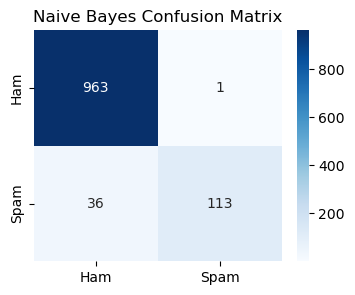


Training SVM...
SVM Accuracy: 0.9802
Classification Report:
               precision    recall  f1-score   support

           0     0.9806    0.9969    0.9887       964
           1     0.9774    0.8725    0.9220       149

    accuracy                         0.9802      1113
   macro avg     0.9790    0.9347    0.9553      1113
weighted avg     0.9802    0.9802    0.9798      1113



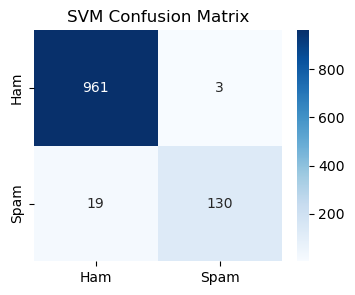


Training Random Forest...
Random Forest Accuracy: 0.9748
Classification Report:
               precision    recall  f1-score   support

           0     0.9718    1.0000    0.9857       964
           1     1.0000    0.8121    0.8963       149

    accuracy                         0.9748      1113
   macro avg     0.9859    0.9060    0.9410      1113
weighted avg     0.9756    0.9748    0.9737      1113



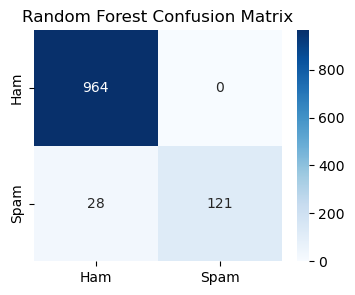

In [9]:
print("\n8) Training models: MultinomialNB, SVM (linear), RandomForest")
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

trained_models = {}
scores = {}
for name, model in models.items():
    try:
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        scores[name] = acc
        trained_models[name] = model
        print(f"{name} Accuracy: {acc:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
        plt.title(f"{name} Confusion Matrix")
        plt.show()
    except Exception as e:
        print(f"Error training {name}: {e}")

8. Best Model Selection

In [10]:
if not scores:
    raise RuntimeError("No models trained successfully.")
best_name = max(scores, key=scores.get)
best_model = trained_models[best_name]
print(f"\n9) Best model based on accuracy: {best_name} (Accuracy={scores[best_name]:.4f})")


9) Best model based on accuracy: SVM (Accuracy=0.9802)


9. Word Clouds


10) Generating word clouds for spam and ham (may take a moment)...


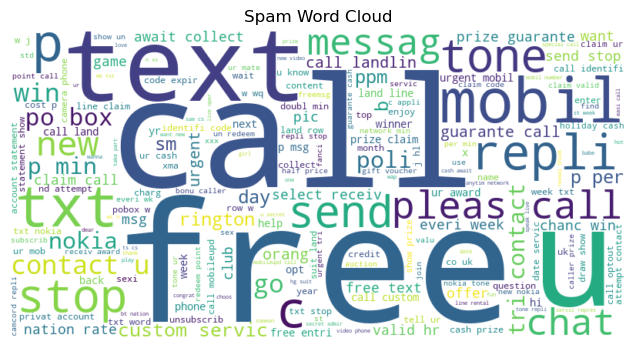

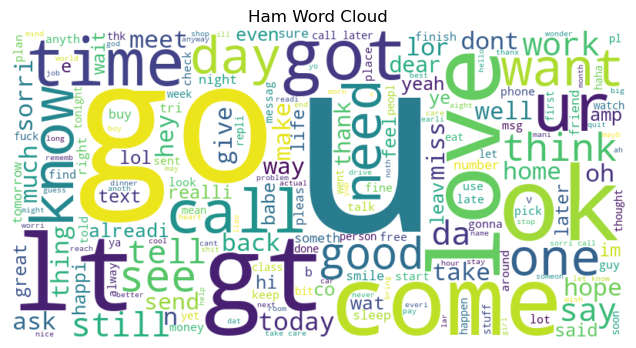

In [11]:
print("\n10) Generating word clouds for spam and ham (may take a moment)...")
try:
    spam_text = " ".join(df[df['label']=='spam']['clean_text'])
    ham_text = " ".join(df[df['label']=='ham']['clean_text'])
    def show_wc(text, title):
        if not text.strip():
            print("No text for", title)
            return
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10,4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(title)
        plt.show()
    show_wc(spam_text, "Spam Word Cloud")
    show_wc(ham_text, "Ham Word Cloud")
except Exception as e:
    print("Word cloud generation failed:", e)

10. Save Model and Vectorizer

In [12]:
model_filename = 'best_spam_model.joblib'
vec_filename = 'tfidf_vectorizer.joblib'
print(f"\n11) Saving best model ({best_name}) to {model_filename} and vectorizer to {vec_filename} ...")
joblib.dump(best_model, model_filename)
joblib.dump(tfidf, vec_filename)

# Download files (Colab)
if files is not None:
    try:
        files.download(model_filename)
        files.download(vec_filename)
    except Exception as e:
        print("Automatic download failed (this sometimes happens). Files are saved in the Colab working directory. Use the file browser to download manually. Error:", e)


11) Saving best model (SVM) to best_spam_model.joblib and vectorizer to tfidf_vectorizer.joblib ...


11. Prediction Function and Testing

In [13]:
print("\n12) Defining predict_email(...) function and testing with samples.")

def predict_email(email_text, model_path=model_filename, vec_path=vec_filename):
    # load model & vectorizer
    m = joblib.load(model_path)
    v = joblib.load(vec_path)
    cleaned = clean_text(email_text)
    vec = v.transform([cleaned]).toarray()
    pred = m.predict(vec)[0]
    prob = None
    try:
        if hasattr(m, "predict_proba"):
            p = m.predict_proba(vec)[0]
            prob = {'ham_prob': f"{p[0]*100:.2f}%", 'spam_prob': f"{p[1]*100:.2f}%"}
    except Exception:
        prob = None
    return {'prediction': 'spam' if pred==1 else 'ham', 'probabilities': prob, 'cleaned_text': cleaned}

# Test samples
sample_ham = "Hi there, just checking in to see if you're free for lunch tomorrow?"
sample_spam = "CONGRATULATIONS!! You've won a $1000 Walmart gift card. Click here to claim!"

print("Sample ham ->", predict_email(sample_ham))
print("Sample spam ->", predict_email(sample_spam))




12) Defining predict_email(...) function and testing with samples.
Sample ham -> {'prediction': 'ham', 'probabilities': {'ham_prob': '99.46%', 'spam_prob': '0.54%'}, 'cleaned_text': 'hi check see free lunch tomorrow'}
Sample spam -> {'prediction': 'spam', 'probabilities': {'ham_prob': '25.32%', 'spam_prob': '74.68%'}, 'cleaned_text': 'congratul walmart gift card click claim'}
